In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

from sklearn import preprocessing

In [ ]:
df_raw = pd.read_csv("/content/drive/MyDrive/Datasets/Crypto/coin_Bitcoin.csv")
df_raw = df_raw.drop(columns=['SNo','Name','Symbol'])
df_orig = pd.read_csv("/content/drive/MyDrive/Datasets/Crypto/coin_Bitcoin.csv")


In [ ]:
df_raw.tail()

,Date,High,Low,Open,Close,Volume,Marketcap
2986,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2990,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [ ]:
# helper functions

def getratio(data):
  ratios = []
  ratios.append(1)
  # data +=1e-20
  for i in range(1,len(data)):
    if data[i] ==0 or data[i-1] ==0:
      ratios.append(np.nan)
    else:
      ratios.append(data[i]/data[i-1])
  return ratios
def takeratio(df, col1, col2):
  temp = []
  for i in range(len(df)):
    temp.append(df.loc[i,col1]/df.loc[i,col2])
  return temp


def preprocess(dataf):
  df1 = dataf.copy()
  #Get the the total number of shares in the market using market cap and closing price 
  num_shares = list()
  for i in range(len(df1)):
    num_shares.append(df1.loc[i,'Marketcap']/df1.loc[i,'Close'])
  df1['Numshares'] = num_shares
  df1 = df1.drop(columns=['Marketcap'])


  #Create features

  # 1. ratio of x_[i] and x_[i-1] for each numeric column
  for col in df1.columns:
    if col == 'Date':
      continue
    df1[col+"_ratio"] = getratio(df1[col])
  # 2. ratio of High Low and Close Open
  df1["HighLowRatio"] = takeratio(df1,"High","Low")
  df1["CloseOpenRatio"] = takeratio(df1,"Close","Open")
  return df1

In [ ]:
df = preprocess(df_raw)
df.head()

,Date,High,Low,Open,Close,Volume,Numshares,High_ratio,Low_ratio,Open_ratio,Close_ratio,Volume_ratio,Numshares_ratio,HighLowRatio,CloseOpenRatio
0,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.109568e+07,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.100657,1.075094
1,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.109938e+07,0.996217,1.000373,1.071078,0.961672,NaN,1.000333,1.096083,0.965278
2,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.110313e+07,0.952086,0.803581,0.965278,0.841655,NaN,1.000338,1.298645,0.841655
3,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.110653e+07,0.897848,0.856683,0.837266,0.899308,NaN,1.000306,1.361047,0.904021
4,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.110992e+07,0.860892,0.857156,0.912958,0.929094,NaN,1.000306,1.366979,0.920000


Val Test train split

In [63]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

temp = df_train.drop(columns=['Date']).copy()
imputer = KNNImputer(n_neighbors=3, weights="uniform", missing_values=df.loc[3,'Volume_ratio'])
imputer.fit(temp)

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [64]:
def fillnans(imputer, data):
  temp = data.drop(columns=['Date']).copy()
  data.loc[:,data.columns[1:]] = imputer.transform(temp)
  data = data.set_index('Date')
  return data

df_train = fillnans(imputer, df_train)
df_train = df_train.tail(-1)
df_val = fillnans(imputer, df_val)
df_test = fillnans(imputer, df_test)


# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2392, 14)
Validation data shape: (299, 14)
Test data shape: (299, 14)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [62]:
df_train.head()

,High,Low,Open,Close,Volume,Numshares,High_ratio,Low_ratio,Open_ratio,Close_ratio,Volume_ratio,Numshares_ratio,HighLowRatio,CloseOpenRatio
Date,,,,,,,,,,,,,,
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.110313e+07,0.952086,0.803581,0.965278,0.841655,0.808361,1.000338,1.298645,0.841655
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.110653e+07,0.897848,0.856683,0.837266,0.899308,0.808361,1.000306,1.361047,0.904021
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.110992e+07,0.860892,0.857156,0.912958,0.929094,0.808361,1.000306,1.366979,0.920000
2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.111392e+07,1.063554,1.169406,0.923294,1.150895,0.808361,1.000360,1.243243,1.146789
2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.111805e+07,1.033044,1.158303,1.150866,1.030311,0.808361,1.000371,1.108799,1.026661


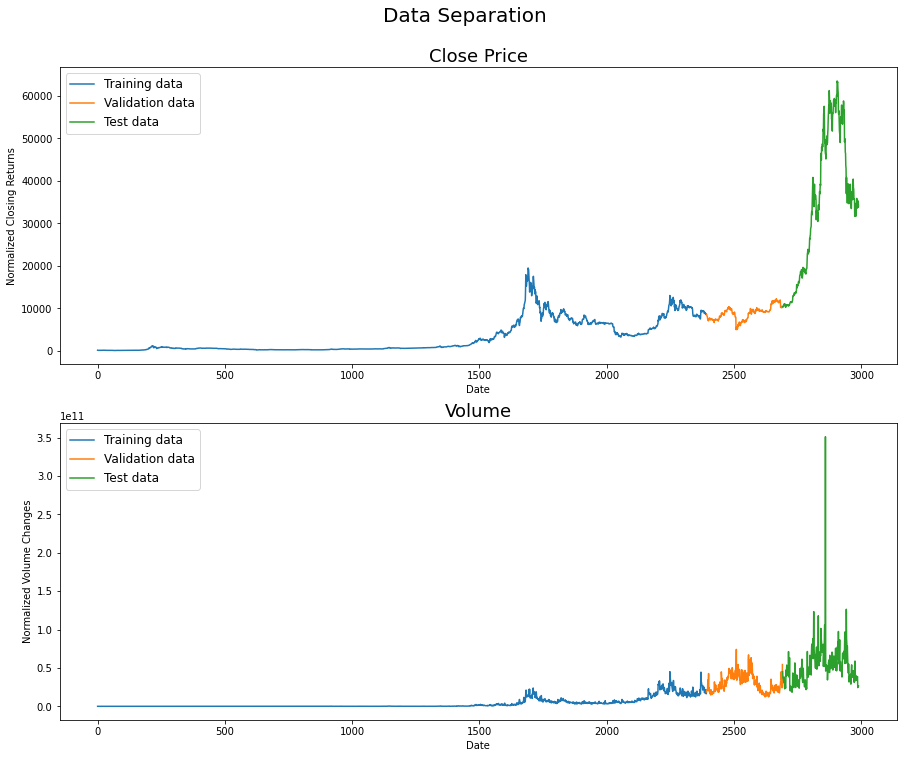

In [65]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

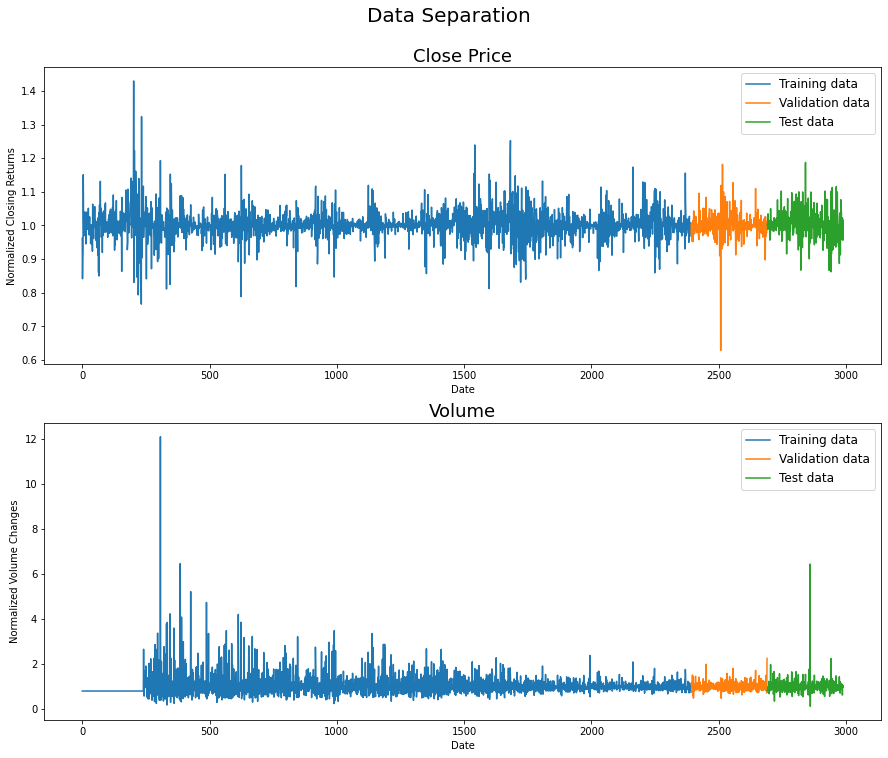

In [66]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close_ratio'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close_ratio'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close_ratio'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume_ratio'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume_ratio'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume_ratio'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [67]:
seq_len = 25
test_col = 9
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, test_col][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, test_col][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, test_col][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

In [68]:
model = models.Sequential()
model.add(LSTM(units = 100, use_bias=True, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
model.add(GRU(units = 50, activation = 'relu', return_sequences = True, use_bias=True))
# model.add(Dropout(0.2))
model.add(LSTM(units = 10, use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(units = 1))


callback = tf.keras.callbacks.ModelCheckpoint('lstm_baseline.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

In [70]:
model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['mae','mape'])
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.3733 - mae: 0.9645 - mape: 96.3155
Epoch 00001: val_loss improved from inf to 1.59473, saving model to lstm_baseline.hdf5
74/74 [==============================] - 9s 57ms/step - loss: 1.3733 - mae: 0.9645 - mape: 96.3155 - val_loss: 1.5947 - val_mae: 1.1566 - val_mape: 115.4752
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.1956 - mae: 0.9007 - mape: 89.8114
Epoch 00002: val_loss improved from 1.59473 to 1.32316, saving model to lstm_baseline.hdf5
74/74 [==============================] - 4s 50ms/step - loss: 1.1956 - mae: 0.9007 - mape: 89.8114 - val_loss: 1.3232 - val_mae: 1.0492 - val_mape: 104.7680
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 1.0069 - mae: 0.8167 - mape: 81.5218
Epoch 00003: val_loss improved from 1.32316 to 1.08895, saving model to lstm_baseline.hdf5
74/74 [==============================] - 4s 48ms/step - loss: 1.0069 - mae: 0.8167 - mape: 81.5218 - v

In [71]:
model = tf.keras.models.load_model('/content/lstm_baseline.hdf5')


 
Evaluation metrics
Training Data - Loss: 0.0028, MAE: 0.0307, MAPE: 3.0706
Validation Data - Loss: 0.0018, MAE: 0.0253, MAPE: 2.5836
Test Data - Loss: 0.0022, MAE: 0.0342, MAPE: 3.3992


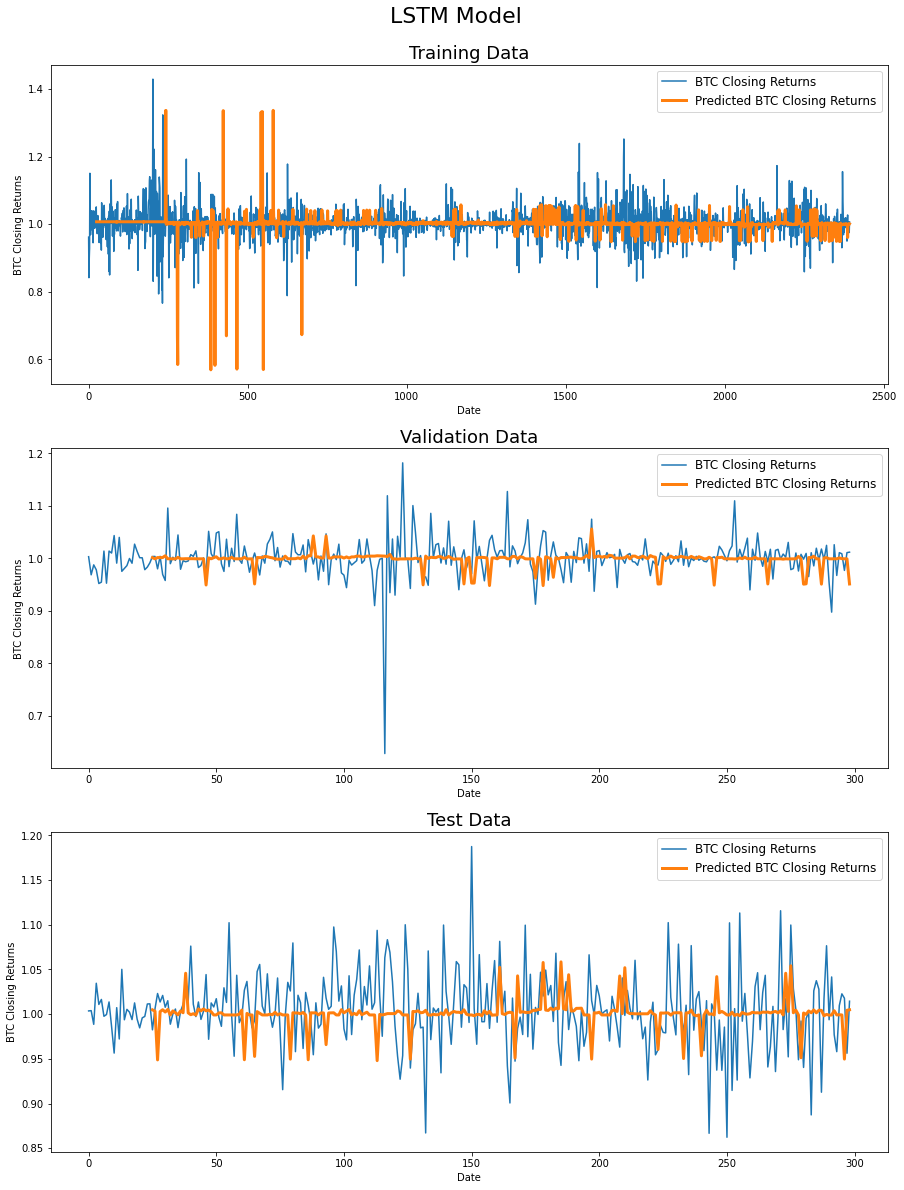

In [72]:

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, test_col], label='BTC Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred[:,-1], linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, test_col], label='BTC Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred[:,-1], linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, test_col], label='BTC Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred[:,-1], linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)
plt.show()